In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn.functional as F
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

print("Loading Hindi TinyStories model and tokenizer...")
model_path = '/kaggle/input/hi-tinystories/pytorch/default/1/hi_tinystories'  # Update this path
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, attn_implementation="eager")
model.eval()

# Set pad token if not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Setup complete.")
print(f"Model config: {model.config}")

Loading Hindi TinyStories model and tokenizer...


2025-11-07 18:00:59.175625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762538459.402675      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762538459.468273      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Setup complete.
Model config: GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "dtype": "float32",
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 384,
  "n_head": 6,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 512,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.53.3",
  "use_cache": true,
  "vocab_size": 19360
}



In [3]:
def find_token_position(tokens, target_word):
    """Helper function to find token position in Hindi text."""
    # First try exact match
    try:
        return tokens.index(target_word)
    except ValueError:
        # Try with common prefixes that tokenizers might add
        for prefix in ['▁', 'Ġ', '##', '']:
            try:
                return tokens.index(prefix + target_word)
            except ValueError:
                continue
        
        # Try substring match (important for Hindi compound words)
        for i, token in enumerate(tokens):
            # Remove common prefixes before comparing
            clean_token = token.lstrip('▁Ġ##')
            clean_target = target_word.lstrip('▁Ġ##')
            if clean_target in clean_token or clean_token in clean_target:
                return i
        
        raise ValueError(f"Token '{target_word}' not found in {tokens}")

def analyze_semantic_role_attention(sentence, arg0, arg1, predicate):
    """
    Analyzes all 6 semantic role attention patterns for a single sentence.
    NOTE: For Hindi SOV, the typical order is: Subject (arg0) - Object (arg1) - Verb (predicate)
    """
    inputs = tokenizer(sentence, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    print(f"Sentence: {sentence}")
    print(f"Tokens: {tokens}")
    print(f"Looking for - Subject(arg0): '{arg0}', Object(arg1): '{arg1}', Verb(predicate): '{predicate}'")
    
    try:
        arg0_pos = find_token_position(tokens, arg0)
        arg1_pos = find_token_position(tokens, arg1)
        pred_pos = find_token_position(tokens, predicate)
        print(f"Positions - Subject: {arg0_pos}, Object: {arg1_pos}, Verb: {pred_pos}")
    except ValueError as e:
        print(f"Error: {e}")
        return None

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    n_layers = model.config.num_hidden_layers if hasattr(model.config, 'num_hidden_layers') else model.config.n_layer
    n_heads = model.config.num_attention_heads if hasattr(model.config, 'num_attention_heads') else model.config.n_head
    
    results = {}
    for layer in range(n_layers):
        attention = outputs.attentions[layer].squeeze(0)
        layer_results = {}
        for head in range(n_heads):
            p = {
                # Subject-Verb relationships
                'subj_to_verb': attention[head, arg0_pos, pred_pos].item(),
                'verb_to_subj': attention[head, pred_pos, arg0_pos].item(),
                # Object-Verb relationships
                'obj_to_verb': attention[head, arg1_pos, pred_pos].item(),
                'verb_to_obj': attention[head, pred_pos, arg1_pos].item(),
                # Subject-Object relationships (important in SOV!)
                'subj_to_obj': attention[head, arg0_pos, arg1_pos].item(),
                'obj_to_subj': attention[head, arg1_pos, arg0_pos].item()
            }
            layer_results[head] = p
        results[layer] = layer_results
    return results

def visualize_all_layers_for_sentence(text):
    """Visualizes the attention patterns for all heads in every layer for a sentence."""
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    n_layers = model.config.num_hidden_layers if hasattr(model.config, 'num_hidden_layers') else model.config.n_layer
    n_heads = model.config.num_attention_heads if hasattr(model.config, 'num_attention_heads') else model.config.n_head
    
    for layer_idx, attention in enumerate(outputs.attentions):
        attention = attention.squeeze(0).detach().numpy()
        
        rows = int(np.ceil(n_heads / 4))
        fig, axes = plt.subplots(rows, 4, figsize=(16, rows*4))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle(f'All Attention Heads for Layer {layer_idx}\nSentence: "{text}"', fontsize=20)
        
        for head_idx in range(n_heads):
            ax = axes[head_idx // 4, head_idx % 4]
            sns.heatmap(attention[head_idx], xticklabels=tokens, yticklabels=tokens, 
                       cmap='viridis', ax=ax, cbar=False)
            ax.set_title(f'Head {head_idx}')
            ax.tick_params(axis='x', rotation=90)
        
        for idx in range(n_heads, rows * 4):
            axes[idx // 4, idx % 4].axis('off')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [13]:
class CircuitAnalyzer:
    """A class to systematically find, validate, and test a circuit of specialist heads."""

    def __init__(self, name, relationship_key):
        self.name = name
        self.relationship_key = relationship_key
        self.specialist_heads = []
        print(f"Initialized analyzer for '{self.name}' ({self.relationship_key}) circuit.")

    def find_specialists(self, test_cases, threshold=0.4):
        head_scores = {}
        for case in test_cases:
            # Note: passing in SOV order
            results = analyze_semantic_role_attention(case['sentence'], case['arg0'], 
                                                     case['arg1'], case['predicate'])
            if results is None:
                continue
            
            n_layers = model.config.num_hidden_layers if hasattr(model.config, 'num_hidden_layers') else model.config.n_layer
            n_heads = model.config.num_attention_heads if hasattr(model.config, 'num_attention_heads') else model.config.n_head
            
            for layer in range(n_layers):
                for head in range(n_heads):
                    score = results[layer][head][self.relationship_key]
                    key = (layer, head)
                    if key not in head_scores:
                        head_scores[key] = []
                    head_scores[key].append(score)
        
        candidates = []
        for (layer, head), scores in head_scores.items():
            if np.mean(scores) > threshold and np.min(scores) > threshold * 0.3:
                candidates.append({
                    'layer': layer, 
                    'head': head, 
                    'avg_score': np.mean(scores), 
                    'min_score': np.min(scores)
                })
        
        candidates.sort(key=lambda x: x['avg_score'], reverse=True)
        self.specialist_heads = [(c['layer'], c['head']) for c in candidates]
        
        print(f"\n--- DISCOVERY: Found {len(self.specialist_heads)} candidates for '{self.name}' circuit ---")
        for i, head in enumerate(candidates[:5]):
            print(f"  {i+1}. L{head['layer']}H{head['head']} | Avg Score: {head['avg_score']:.4f} | Min Score: {head['min_score']:.4f}")
        
        return self

    def run_distance_test(self, distance_cases):
        if not self.specialist_heads:
            print(f"\n--- VALIDATION (DISTANCE): No heads to test. Skipping. ---")
            return self
        
        print(f"\n--- VALIDATION (DISTANCE): Testing top 5 specialists for '{self.name}' circuit ---")
        for case in distance_cases:
            results = analyze_semantic_role_attention(case['sentence'], case['arg0'], 
                                                     case['arg1'], case['predicate'])
            if results is None:
                continue
                
            print(f"On sentence: '{case['sentence']}'")
            print(f"  {'Head':<8} {'Score':<10}")
            for layer, head in self.specialist_heads[:5]:
                score = results[layer][head][self.relationship_key]
                print(f"  L{layer}H{head:<5} {score:<10.4f}")
        
        return self

    def _perform_single_ablation(self, prompt, heads_to_ablate, verbose=True):
        """Helper function with full sentence generation AND top-5 token analysis."""
        inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
        
        n_heads = model.config.num_attention_heads if hasattr(model.config, 'num_attention_heads') else model.config.n_head
        hidden_size = model.config.hidden_size if hasattr(model.config, 'hidden_size') else model.config.n_embd
        head_dim = hidden_size // n_heads
        
        # 1. Baseline (no ablation)
        with torch.no_grad():
            baseline_output = model.generate(
                inputs['input_ids'], 
                max_length=inputs['input_ids'].shape[1] + 10,
                pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else tokenizer.pad_token_id,
                do_sample=False
            )
            baseline_text = tokenizer.decode(baseline_output[0], skip_special_tokens=True)
            baseline_logits = model(**inputs).logits[0, -1, :]
            baseline_probs = F.softmax(baseline_logits, dim=-1)
            baseline_top5 = torch.topk(baseline_probs, 5)
    
        # 2. Ablated run
        hooks = []
        def create_hook(h):
            def hook_fn(module, input, output):
                output[0][:, :, h*head_dim:(h+1)*head_dim] = 0
                return output
            return hook_fn
        
        # Get the correct layer structure for the model
        try:
            if hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
                layers = model.transformer.h
                attn_module = 'attn'
            elif hasattr(model, 'model') and hasattr(model.model, 'layers'):
                layers = model.model.layers
                attn_module = 'self_attn'
            else:
                # Fallback - try to detect automatically
                layers = model.transformer.h if hasattr(model, 'transformer') else model.model.layers
                attn_module = 'attn'
        except:
            print("Warning: Could not detect model structure, using default GPT-2 style")
            layers = model.transformer.h
            attn_module = 'attn'
        
        try:
            for layer, head in heads_to_ablate:
                layer_module = layers[layer]
                attn = getattr(layer_module, attn_module)
                hooks.append(attn.register_forward_hook(create_hook(head)))
            
            with torch.no_grad():
                ablated_output = model.generate(
                    inputs['input_ids'], 
                    max_length=inputs['input_ids'].shape[1] + 10,
                    pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else tokenizer.pad_token_id,
                    do_sample=False
                )
                ablated_text = tokenizer.decode(ablated_output[0], skip_special_tokens=True)
                ablated_logits = model(**inputs).logits[0, -1, :]
                ablated_probs = F.softmax(ablated_logits, dim=-1)
                ablated_top5 = torch.topk(ablated_probs, 5)
        finally:
            for hook in hooks:
                hook.remove()
    
        # 3. Calculate metrics
        generation_changed = baseline_text != ablated_text
        kl_div = F.kl_div(ablated_probs.log(), baseline_probs, reduction='sum').item()
        
        # 4. Store top-5 predictions
        baseline_predictions = [
            {'token': tokenizer.decode(baseline_top5.indices[i]), 
             'prob': baseline_top5.values[i].item()}
            for i in range(5)
        ]
        ablated_predictions = [
            {'token': tokenizer.decode(ablated_top5.indices[i]), 
             'prob': ablated_top5.values[i].item()}
            for i in range(5)
        ]
        
        # 5. Print detailed comparison (if verbose)
        if verbose:
            print(f"\nPrompt: '{prompt}'")
            print("-" * 50)
            
            print("BASELINE Top 5:")
            for i, pred in enumerate(baseline_predictions):
                print(f"  {i+1}. '{pred['token']}' (prob: {pred['prob']:.4f})")
            
            print("\nABLATED Top 5:")
            for i, pred in enumerate(ablated_predictions):
                print(f"  {i+1}. '{pred['token']}' (prob: {pred['prob']:.4f})")
            
            print("\n---")
            print(f"  Baseline Generated: {baseline_text}")
            print(f"  Ablated Generated:  {ablated_text}")
            
            print(f"\n  Generation Changed: {generation_changed}")
            print(f"  KL Divergence: {kl_div:.4f}")
    
        return {
            'prompt': prompt,
            'baseline_text': baseline_text,
            'ablated_text': ablated_text,
            'generation_changed': generation_changed,
            'kl_divergence': kl_div,
            'baseline_top5': baseline_predictions,
            'ablated_top5': ablated_predictions
        }

    def run_ablation_test(self, test_prompts):
        """Runs a multi-stage causal test with detailed summary statistics."""
        if not self.specialist_heads:
            print(f"\n--- CAUSAL TEST (ABLATION): No heads to test. Skipping. ---")
            return self
        
        top_3_heads = self.specialist_heads[:3]
        if not top_3_heads:
            print(f"\n--- CAUSAL TEST (ABLATION): Fewer than 1 head found. Skipping. ---")
            return self
    
        print(f"\n--- CAUSAL TEST (ABLATION): Testing specialists for '{self.name}' circuit ---")
        
        all_results = {
            'individual': [],
            'top3_combined': [],
            'all_combined': []
        }
        
        # Part 1: Individual Head Ablations
        print("\n" + "="*70)
        print("--- Part 1: Ablating Top 3 Heads Individually ---")
        print("="*70)
        
        for i, head in enumerate(top_3_heads):
            print(f"\n>>> Testing Head {i+1}/{len(top_3_heads)}: L{head[0]}H{head[1]}")
            print(f"    Testing across {len(test_prompts)} prompts...")
            
            head_results = []
            for prompt_idx, prompt in enumerate(test_prompts):
                verbose = prompt_idx < 3
                if verbose:
                    print(f"\n  --- Prompt {prompt_idx+1}/{len(test_prompts)} ---")
                
                result = self._perform_single_ablation(prompt, [head], verbose=verbose)
                result['head'] = head
                result['prompt_idx'] = prompt_idx
                head_results.append(result)
            
            all_results['individual'].extend(head_results)
            
            changed_count = sum(1 for r in head_results if r['generation_changed'])
            avg_kl = np.mean([r['kl_divergence'] for r in head_results])
            print(f"\n  Summary for L{head[0]}H{head[1]}:")
            print(f"    Prompts affected: {changed_count}/{len(test_prompts)}")
            print(f"    Average KL Divergence: {avg_kl:.4f}")
        
        # Print overall individual summary
        print("\n" + "-"*70)
        print("SUMMARY - Individual Head Ablations:")
        print("-"*70)
        for head in top_3_heads:
            head_specific_results = [r for r in all_results['individual'] if r['head'] == head]
            changed = sum(1 for r in head_specific_results if r['generation_changed'])
            avg_kl = np.mean([r['kl_divergence'] for r in head_specific_results])
            print(f"  L{head[0]}H{head[1]}: {changed}/{len(test_prompts)} changed (Avg KL: {avg_kl:.4f})")
        
        # Part 2: Top 3 Combined
        print("\n" + "="*70)
        print(f"--- Part 2: Ablating Top 3 Heads Combined ---")
        print("="*70)
        
        for prompt_idx, prompt in enumerate(test_prompts):
            verbose = prompt_idx < 5
            if verbose:
                print(f"\n  --- Prompt {prompt_idx+1}/{len(test_prompts)} ---")
            
            result = self._perform_single_ablation(prompt, top_3_heads, verbose=verbose)
            result['prompt_idx'] = prompt_idx
            all_results['top3_combined'].append(result)
        
        print("\n" + "-"*70)
        print("SUMMARY - Top 3 Combined Ablation:")
        print("-"*70)
        changed_top3 = sum(1 for r in all_results['top3_combined'] if r['generation_changed'])
        avg_kl_top3 = np.mean([r['kl_divergence'] for r in all_results['top3_combined']])
        print(f"Cases where generation changed: {changed_top3}/{len(test_prompts)}")
        print(f"Average KL Divergence: {avg_kl_top3:.4f}")
        
        # Part 3: All Heads Combined
        if len(self.specialist_heads) > len(top_3_heads):
            print("\n" + "="*70)
            print(f"--- Part 3: Ablating All {len(self.specialist_heads)} Found Heads Combined ---")
            print("="*70)
            
            for prompt_idx, prompt in enumerate(test_prompts):
                verbose = prompt_idx < 5
                if verbose:
                    print(f"\n  --- Prompt {prompt_idx+1}/{len(test_prompts)} ---")
                
                result = self._perform_single_ablation(prompt, self.specialist_heads, verbose=verbose)
                result['prompt_idx'] = prompt_idx
                all_results['all_combined'].append(result)
            
            print("\n" + "-"*70)
            print("SUMMARY - All Heads Combined Ablation:")
            print("-"*70)
            changed_all = sum(1 for r in all_results['all_combined'] if r['generation_changed'])
            avg_kl_all = np.mean([r['kl_divergence'] for r in all_results['all_combined']])
            print(f"Cases where generation changed: {changed_all}/{len(test_prompts)}")
            print(f"Average KL Divergence: {avg_kl_all:.4f}")
        
        # Final Summary
        print("\n" + "="*70)
        print("FINAL SUMMARY - Circuit Causality Analysis")
        print("="*70)
        print(f"Circuit: {self.name}")
        print(f"Total specialist heads found: {len(self.specialist_heads)}")
        print(f"Number of test prompts: {len(test_prompts)}")
        print(f"\nIndividual heads (top 3):")
        for head in top_3_heads:
            head_results = [r for r in all_results['individual'] if r['head'] == head]
            changed = sum(1 for r in head_results if r['generation_changed'])
            print(f"  L{head[0]}H{head[1]}: {changed}/{len(test_prompts)} ({100*changed/len(test_prompts):.1f}%)")
        
        print(f"\nTop 3 combined: {changed_top3}/{len(test_prompts)} ({100*changed_top3/len(test_prompts):.1f}%)")
        if len(self.specialist_heads) > len(top_3_heads):
            print(f"All heads combined: {changed_all}/{len(test_prompts)} ({100*changed_all/len(test_prompts):.1f}%)")
        print("="*70 + "\n")
        
        self.ablation_results = all_results
        
        return self


In [14]:
# ==================== HINDI TEST DATA (SOV ORDER) - SURFACE FORMS ====================

main_test_cases = [
    {'sentence': 'लड़के ने गेंद खेली',        'arg0': 'लड़के',        'arg1': 'गेंद',       'predicate': 'खेली'},
    {'sentence': 'लड़की ने सेब खाया',       'arg0': 'लड़की',        'arg1': 'सेब',        'predicate': 'खाया'},
    {'sentence': 'बिल्ली ने दूध पिया',      'arg0': 'बिल्ली',       'arg1': 'दूध',        'predicate': 'पिया'},
    {'sentence': 'कुत्ते ने हड्डी खाई',      'arg0': 'कुत्ते',        'arg1': 'हड्डी',      'predicate': 'खाई'},
    {'sentence': 'माँ ने केक बनाया',         'arg0': 'माँ',          'arg1': 'केक',        'predicate': 'बनाया'},
]

distance_test_cases = [
    {'sentence': 'लड़के ने गेंद खेली', 'arg0': 'लड़के', 'arg1': 'गेंद', 'predicate': 'खेली'},
    
    # Distance +1: Modifier between subject and object
    {'sentence': 'लड़के ने बहुत गेंद खेली', 'arg0': 'लड़के', 'arg1': 'गेंद', 'predicate': 'खेली'},
    
    # Distance +2: Modifiers between subject-object AND object-verb
    {'sentence': 'लड़के ने बहुत गेंद अच्छे से खेली', 'arg0': 'लड़के', 'arg1': 'गेंद', 'predicate': 'खेली'},
]

ablation_prompts = [
    "लड़का खेला और",
    "लड़की हँसी और",
    "बिल्ली दौड़ी और",
    "कुत्ता भौंका और",
    "माँ आई और",
    "पापा गए और",
    "बच्चा रोया और",
    "पक्षी उड़ा और",
    "टिमी खेला और",
    "लिली नाची और",
    "गेंद गिरी और",
    "सेब गिरा और",
    "दूध गिरा और",
    "खिलौना टूटा और",
    "फूल खिला और",
]

# circuits unchanged
circuits_to_analyze = [
    CircuitAnalyzer(name="Subject->Verb", relationship_key='subj_to_verb'),
    CircuitAnalyzer(name="Verb->Subject", relationship_key='verb_to_subj'),
    CircuitAnalyzer(name="Object->Verb", relationship_key='obj_to_verb'),
    CircuitAnalyzer(name="Verb->Object", relationship_key='verb_to_obj'),
    CircuitAnalyzer(name="Subject->Object", relationship_key='subj_to_obj'),
    CircuitAnalyzer(name="Object->Subject", relationship_key='obj_to_subj'),
]


Initialized analyzer for 'Subject->Verb' (subj_to_verb) circuit.
Initialized analyzer for 'Verb->Subject' (verb_to_subj) circuit.
Initialized analyzer for 'Object->Verb' (obj_to_verb) circuit.
Initialized analyzer for 'Verb->Object' (verb_to_obj) circuit.
Initialized analyzer for 'Subject->Object' (subj_to_obj) circuit.
Initialized analyzer for 'Object->Subject' (obj_to_subj) circuit.



--- Running attention visualization on a sample Hindi sentence. ---


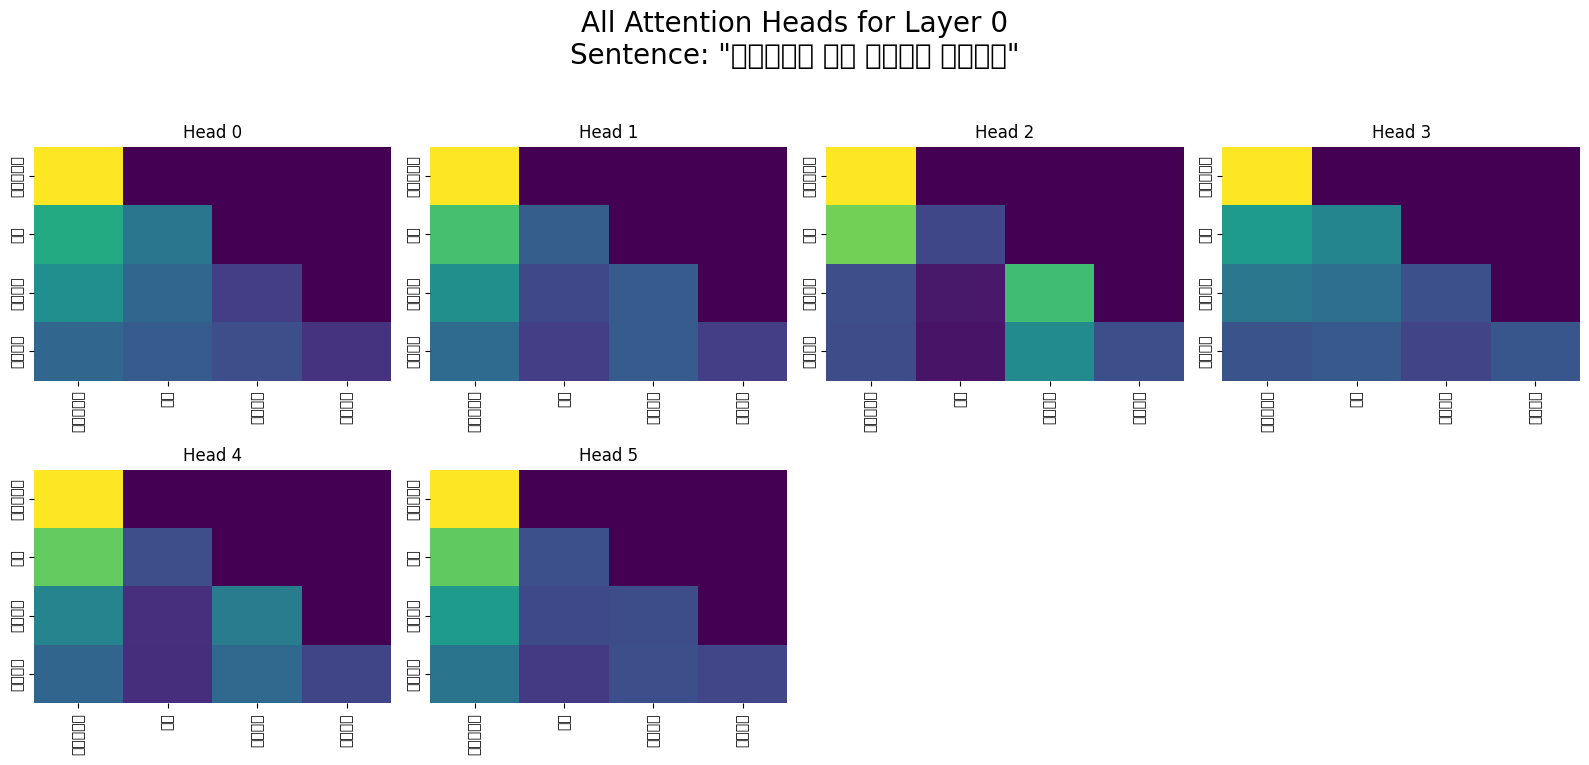

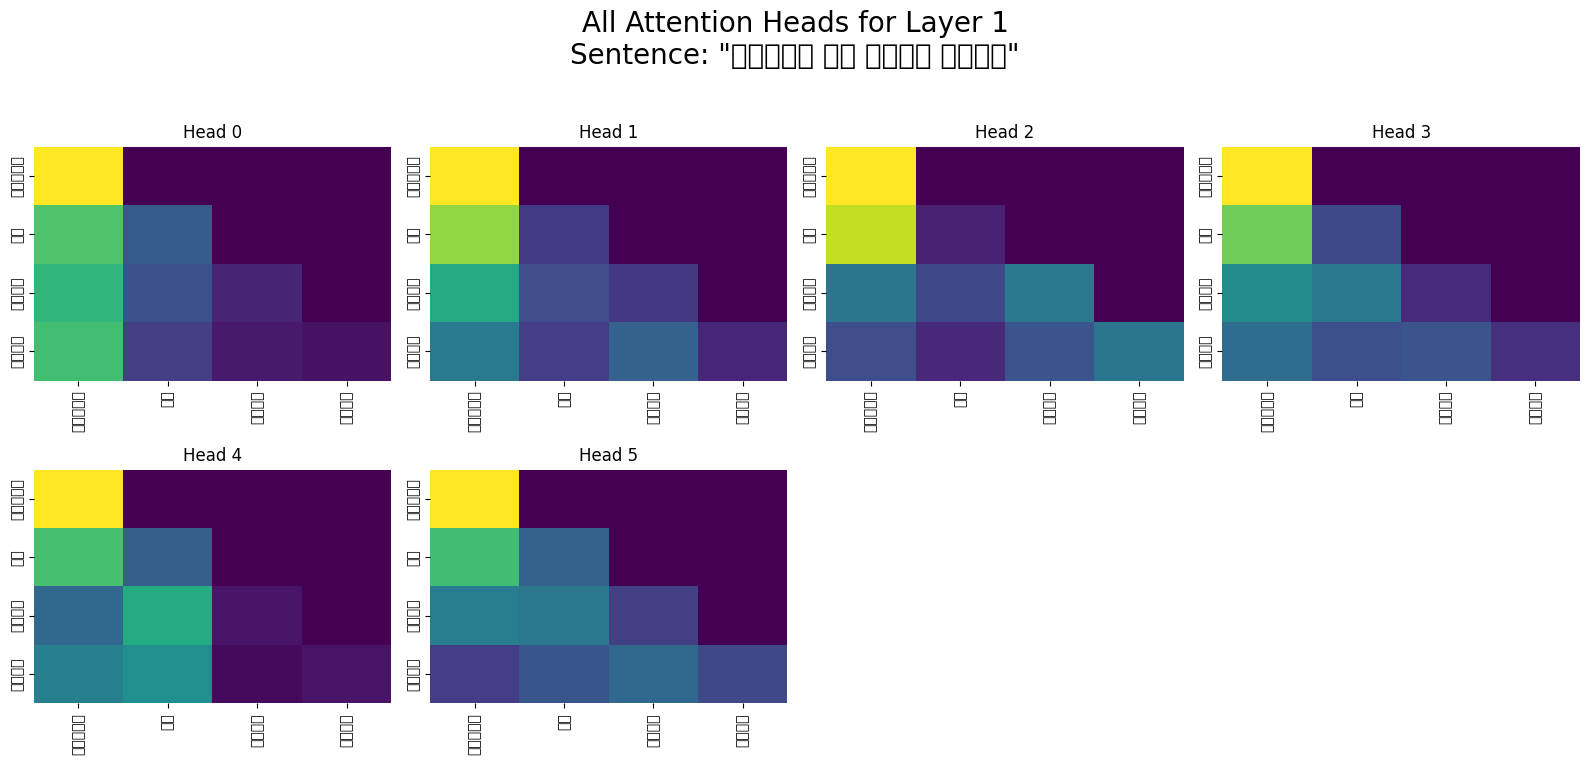

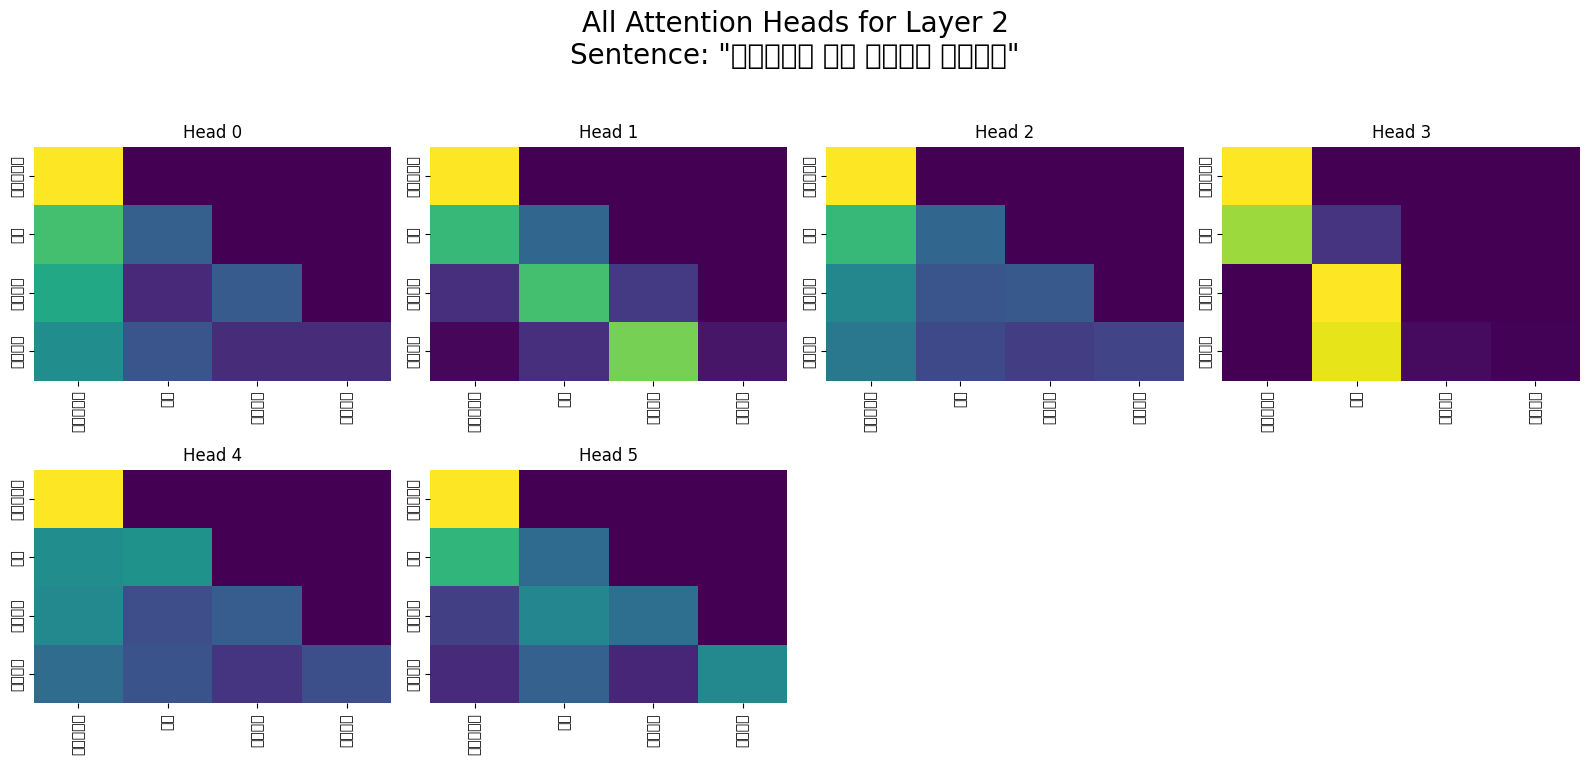

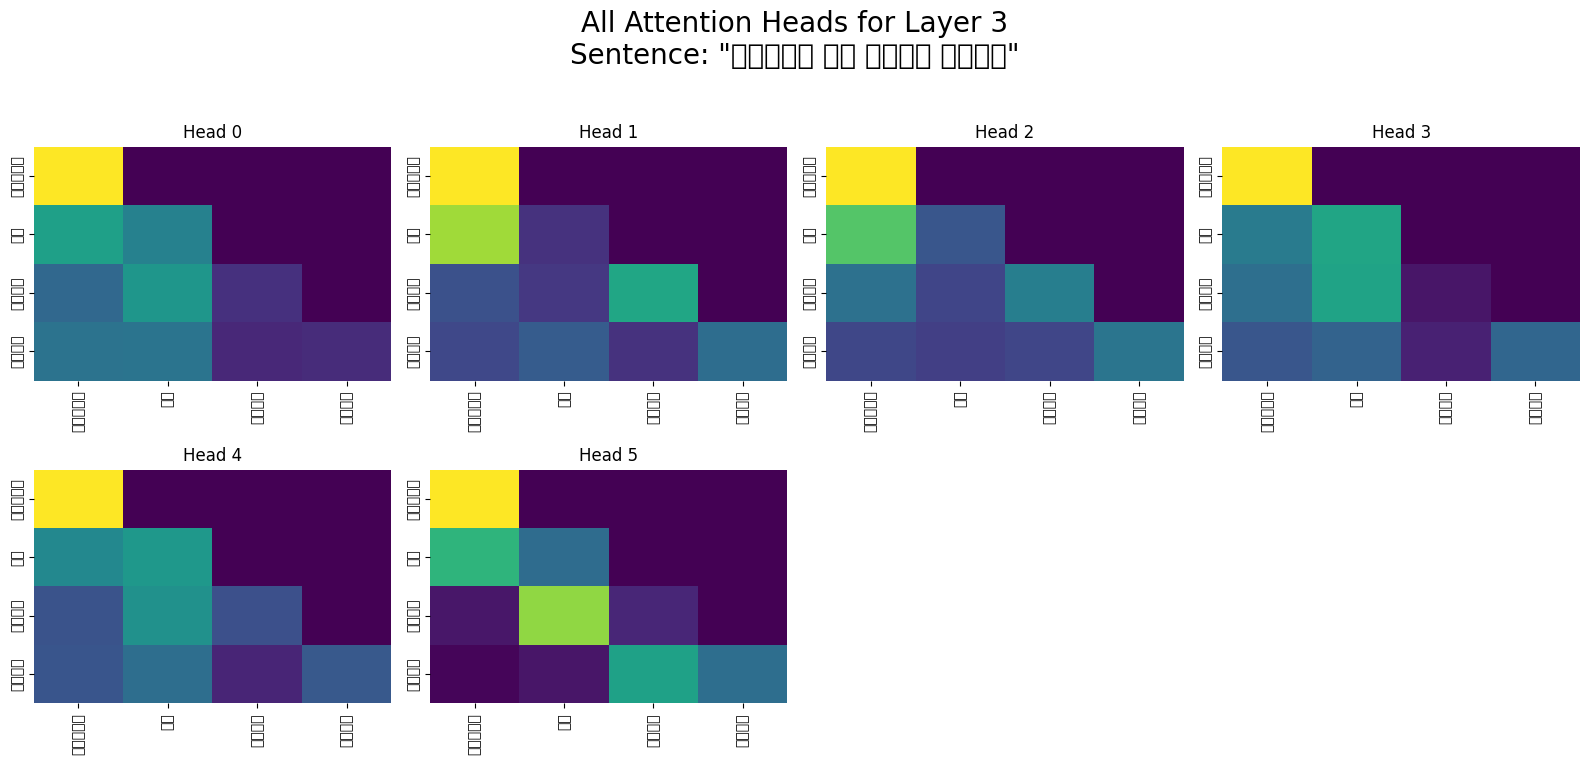

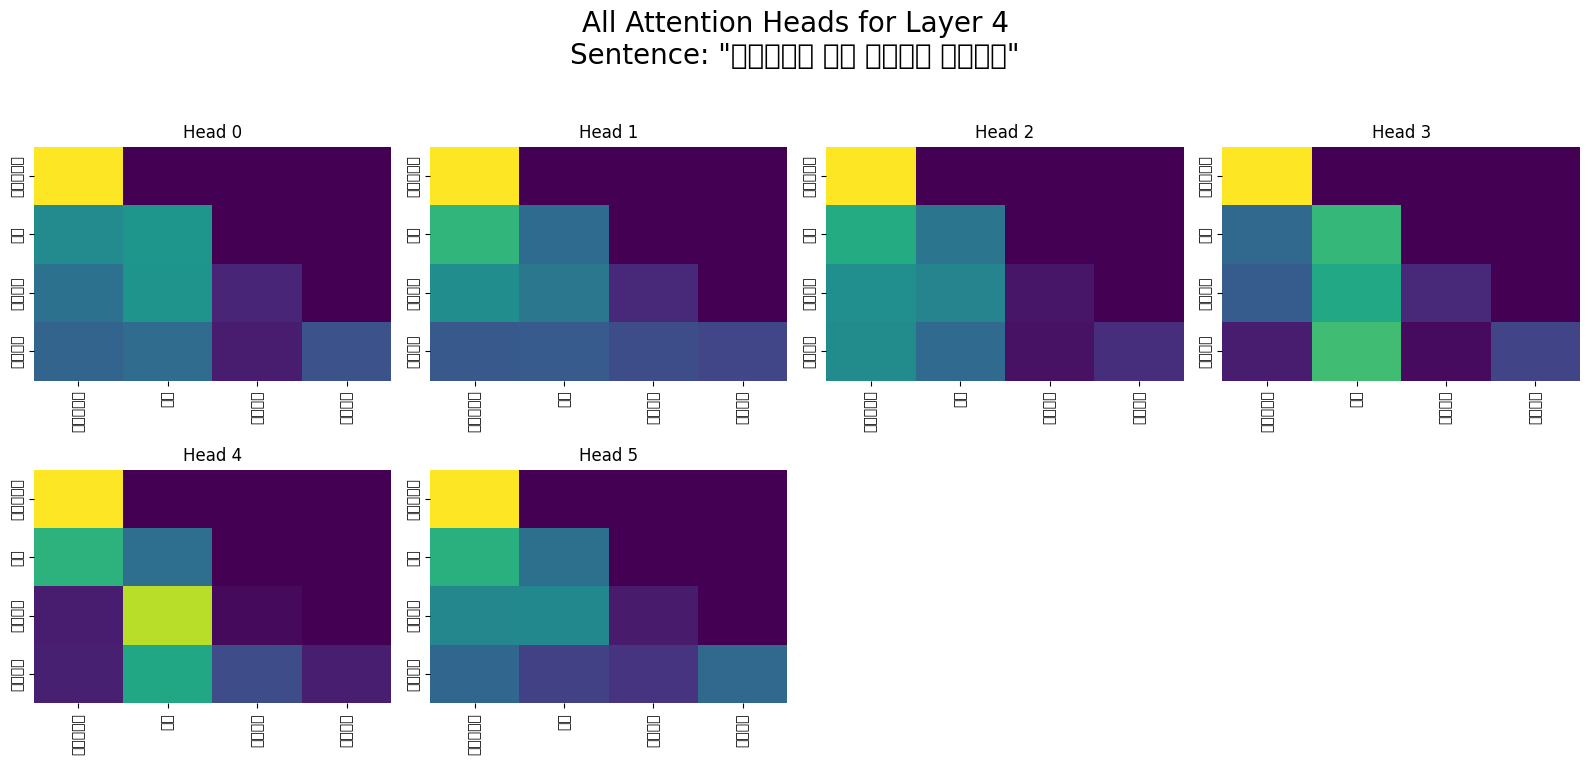

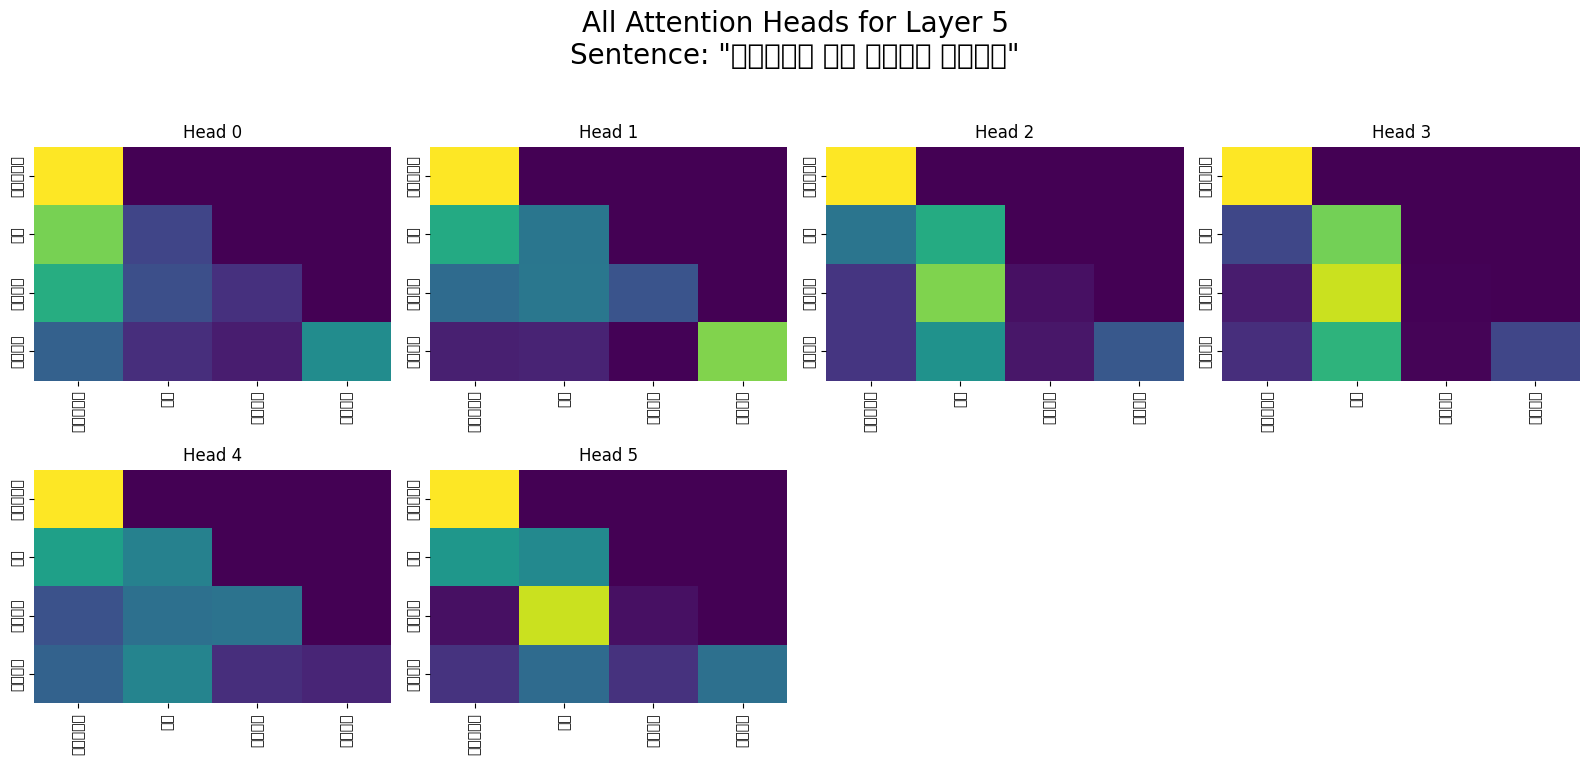

In [15]:
print("\n--- Running attention visualization on a sample Hindi sentence. ---")
visualize_all_layers_for_sentence("लड़के ने गेंद खेली")

In [16]:
# Subject->Verb
print("\n\n### ANALYZING CIRCUIT 1/6: Subject->Verb ###")
circuits_to_analyze[0].find_specialists(main_test_cases, threshold=0.4)\
                      .run_distance_test(distance_test_cases)\
                      .run_ablation_test(ablation_prompts)
 



### ANALYZING CIRCUIT 1/6: Subject->Verb ###
Sentence: लड़के ने गेंद खेली
Tokens: ['लड़के', 'ने', 'गेंद', 'खेली']
Looking for - Subject(arg0): 'लड़के', Object(arg1): 'गेंद', Verb(predicate): 'खेली'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: लड़की ने सेब खाया
Tokens: ['लड़की', 'ने', 'सेब', 'खाया']
Looking for - Subject(arg0): 'लड़की', Object(arg1): 'सेब', Verb(predicate): 'खाया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: बिल्ली ने दूध पिया
Tokens: ['बिल्ली', 'ने', 'दूध', 'पिया']
Looking for - Subject(arg0): 'बिल्ली', Object(arg1): 'दूध', Verb(predicate): 'पिया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: कुत्ते ने हड्डी खाई
Tokens: ['कुत्ते', 'ने', 'हड्डी', 'खाई']
Looking for - Subject(arg0): 'कुत्ते', Object(arg1): 'हड्डी', Verb(predicate): 'खाई'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: माँ ने केक बनाया
Tokens: ['माँ', 'ने', 'केक', 'बनाया']
Looking for - Subject(arg0): 'माँ', Object(arg1): 'केक', Verb(predicate): 'बनाया'
Positions - Subject: 0

In [17]:
print("\n\n### ANALYZING CIRCUIT 2/6: Verb->Subject ###")
circuits_to_analyze[1].find_specialists(main_test_cases, threshold=0.4)\
                      .run_distance_test(distance_test_cases)\
                      .run_ablation_test(ablation_prompts)




### ANALYZING CIRCUIT 2/6: Verb->Subject ###
Sentence: लड़के ने गेंद खेली
Tokens: ['लड़के', 'ने', 'गेंद', 'खेली']
Looking for - Subject(arg0): 'लड़के', Object(arg1): 'गेंद', Verb(predicate): 'खेली'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: लड़की ने सेब खाया
Tokens: ['लड़की', 'ने', 'सेब', 'खाया']
Looking for - Subject(arg0): 'लड़की', Object(arg1): 'सेब', Verb(predicate): 'खाया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: बिल्ली ने दूध पिया
Tokens: ['बिल्ली', 'ने', 'दूध', 'पिया']
Looking for - Subject(arg0): 'बिल्ली', Object(arg1): 'दूध', Verb(predicate): 'पिया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: कुत्ते ने हड्डी खाई
Tokens: ['कुत्ते', 'ने', 'हड्डी', 'खाई']
Looking for - Subject(arg0): 'कुत्ते', Object(arg1): 'हड्डी', Verb(predicate): 'खाई'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: माँ ने केक बनाया
Tokens: ['माँ', 'ने', 'केक', 'बनाया']
Looking for - Subject(arg0): 'माँ', Object(arg1): 'केक', Verb(predicate): 'बनाया'
Positions - Subject: 0

In [51]:
 # Object->Verb
print("\n\n### ANALYZING CIRCUIT 3/6: Object->Verb ###")
circuits_to_analyze[2].find_specialists(main_test_cases, threshold=0.4)\
                      .run_distance_test(distance_test_cases)\
                      .run_ablation_test(ablation_prompts)



### ANALYZING CIRCUIT 3/6: Object->Verb ###
Sentence: लड़के ने गेंद खेली
Tokens: ['लड़के', 'ने', 'गेंद', 'खेली']
Looking for - Subject(arg0): 'लड़के', Object(arg1): 'गेंद', Verb(predicate): 'खेली'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: लड़की ने सेब खाया
Tokens: ['लड़की', 'ने', 'सेब', 'खाया']
Looking for - Subject(arg0): 'लड़की', Object(arg1): 'सेब', Verb(predicate): 'खाया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: बिल्ली ने दूध पिया
Tokens: ['बिल्ली', 'ने', 'दूध', 'पिया']
Looking for - Subject(arg0): 'बिल्ली', Object(arg1): 'दूध', Verb(predicate): 'पिया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: कुत्ते ने हड्डी खाई
Tokens: ['कुत्ते', 'ने', 'हड्डी', 'खाई']
Looking for - Subject(arg0): 'कुत्ते', Object(arg1): 'हड्डी', Verb(predicate): 'खाई'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: माँ ने केक बनाया
Tokens: ['माँ', 'ने', 'केक', 'बनाया']
Looking for - Subject(arg0): 'माँ', Object(arg1): 'केक', Verb(predicate): 'बनाया'
Positions - Subject: 0,

In [18]:
# Verb->Object
print("\n\n### ANALYZING CIRCUIT 4/6: Verb->Object ###")
circuits_to_analyze[3].find_specialists(main_test_cases, threshold=0.4)\
                      .run_distance_test(distance_test_cases)\
                      .run_ablation_test(ablation_prompts)



### ANALYZING CIRCUIT 4/6: Verb->Object ###
Sentence: लड़के ने गेंद खेली
Tokens: ['लड़के', 'ने', 'गेंद', 'खेली']
Looking for - Subject(arg0): 'लड़के', Object(arg1): 'गेंद', Verb(predicate): 'खेली'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: लड़की ने सेब खाया
Tokens: ['लड़की', 'ने', 'सेब', 'खाया']
Looking for - Subject(arg0): 'लड़की', Object(arg1): 'सेब', Verb(predicate): 'खाया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: बिल्ली ने दूध पिया
Tokens: ['बिल्ली', 'ने', 'दूध', 'पिया']
Looking for - Subject(arg0): 'बिल्ली', Object(arg1): 'दूध', Verb(predicate): 'पिया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: कुत्ते ने हड्डी खाई
Tokens: ['कुत्ते', 'ने', 'हड्डी', 'खाई']
Looking for - Subject(arg0): 'कुत्ते', Object(arg1): 'हड्डी', Verb(predicate): 'खाई'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: माँ ने केक बनाया
Tokens: ['माँ', 'ने', 'केक', 'बनाया']
Looking for - Subject(arg0): 'माँ', Object(arg1): 'केक', Verb(predicate): 'बनाया'
Positions - Subject: 0,

In [53]:
# Subject->Object
print("\n\n### ANALYZING CIRCUIT 5/6: Subject->Object ###")
circuits_to_analyze[4].find_specialists(main_test_cases, threshold=0.4)\
                      .run_distance_test(distance_test_cases)\
                      .run_ablation_test(ablation_prompts)



### ANALYZING CIRCUIT 5/6: Subject->Object ###
Sentence: लड़के ने गेंद खेली
Tokens: ['लड़के', 'ने', 'गेंद', 'खेली']
Looking for - Subject(arg0): 'लड़के', Object(arg1): 'गेंद', Verb(predicate): 'खेली'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: लड़की ने सेब खाया
Tokens: ['लड़की', 'ने', 'सेब', 'खाया']
Looking for - Subject(arg0): 'लड़की', Object(arg1): 'सेब', Verb(predicate): 'खाया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: बिल्ली ने दूध पिया
Tokens: ['बिल्ली', 'ने', 'दूध', 'पिया']
Looking for - Subject(arg0): 'बिल्ली', Object(arg1): 'दूध', Verb(predicate): 'पिया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: कुत्ते ने हड्डी खाई
Tokens: ['कुत्ते', 'ने', 'हड्डी', 'खाई']
Looking for - Subject(arg0): 'कुत्ते', Object(arg1): 'हड्डी', Verb(predicate): 'खाई'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: माँ ने केक बनाया
Tokens: ['माँ', 'ने', 'केक', 'बनाया']
Looking for - Subject(arg0): 'माँ', Object(arg1): 'केक', Verb(predicate): 'बनाया'
Positions - Subject:

In [19]:
# Object->Subject
print("\n\n### ANALYZING CIRCUIT 6/6: Object->Subject ###")
circuits_to_analyze[5].find_specialists(main_test_cases, threshold=0.4)\
                      .run_distance_test(distance_test_cases)\
                      .run_ablation_test(ablation_prompts)




### ANALYZING CIRCUIT 6/6: Object->Subject ###
Sentence: लड़के ने गेंद खेली
Tokens: ['लड़के', 'ने', 'गेंद', 'खेली']
Looking for - Subject(arg0): 'लड़के', Object(arg1): 'गेंद', Verb(predicate): 'खेली'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: लड़की ने सेब खाया
Tokens: ['लड़की', 'ने', 'सेब', 'खाया']
Looking for - Subject(arg0): 'लड़की', Object(arg1): 'सेब', Verb(predicate): 'खाया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: बिल्ली ने दूध पिया
Tokens: ['बिल्ली', 'ने', 'दूध', 'पिया']
Looking for - Subject(arg0): 'बिल्ली', Object(arg1): 'दूध', Verb(predicate): 'पिया'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: कुत्ते ने हड्डी खाई
Tokens: ['कुत्ते', 'ने', 'हड्डी', 'खाई']
Looking for - Subject(arg0): 'कुत्ते', Object(arg1): 'हड्डी', Verb(predicate): 'खाई'
Positions - Subject: 0, Object: 2, Verb: 3
Sentence: माँ ने केक बनाया
Tokens: ['माँ', 'ने', 'केक', 'बनाया']
Looking for - Subject(arg0): 'माँ', Object(arg1): 'केक', Verb(predicate): 'बनाया'
Positions - Subject: